# Linear Regression With Stochastic Gradient Descent

In this project we will employ a linear regression model with stochastic gradient descent. The dataset we're using is the "Crowdedness at the Campus Gym" dataset, and our objective is to predict the best time to go to the gym to avoid the crowds.

Below is a breakdown of the columns in the dataset:

`number_people`: this is the number of people at the gym at each observation. This will be our target variable or label.

`date`: a string value with the specific date and time information.

`timestamp`: an integer (int), with the number of seconds since the start of the day (00:00).

`dayofweek`: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.

`is_weekend`: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.

`is_holiday`: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.

`temperature`: a float, defining the temperature during the day of the observation in Fahrenheit.

`is_startof_semester`: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.

`is_during_semester`: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.

`month`: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.

`hour`: an integer (int) for the hour of the day from 0 to 23.

## Overview

In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import SDGRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

gym = pd.read_csv('crowdness_gym_data.csv')

In [41]:
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [42]:
#quick descriptive statistics
gym.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


In [43]:
#checking null values -- this data is clean so these steps arent really necessary, but are good habits nonetheless
gym.isnull().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

In [44]:
#checking corr of potential features 
gym.corr().unstack()['number_people'].sort_values(ascending=False).drop_duplicates().head(10)

number_people           1.000000
hour                    0.552049
timestamp               0.550218
temperature             0.373327
is_during_semester      0.335350
is_start_of_semester    0.182683
is_holiday             -0.048249
month                  -0.097854
day_of_week            -0.162062
is_weekend             -0.173958
dtype: float64

We can see based on the above list of correlations, after disregarding the valuese that don't make sense, a few emerge as initial contenders for predictors in our model:

`hour` , `temperature`, `is_during_semester` 

Notice we must keep some of the correlations among potential predictors in mind. For example, `timestamp` and `hour` are highly correlated -- we cannot use both of these in our regression without violating the no multicollinearity assumption. 

We should also keep an eye on `day_of_week` and `is_weekend` as they have negative correlations with our outcome variable.

Also, becasuse we have time information captured by other variables, we can drop the `timestamp` and `date` columns. 

In [45]:
gym.drop(['timestamp', 'date'], axis=1, inplace=True)

In [46]:
gym.head()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,4,0,0,71.76,0,0,8,17
1,45,4,0,0,71.76,0,0,8,17
2,40,4,0,0,71.76,0,0,8,17
3,44,4,0,0,71.76,0,0,8,17
4,45,4,0,0,71.76,0,0,8,17


## Exploratory Data Analysis

Now that we've looked at our variables, and established which ones are worth keeping, let's take a deeper dive. 

<AxesSubplot:>

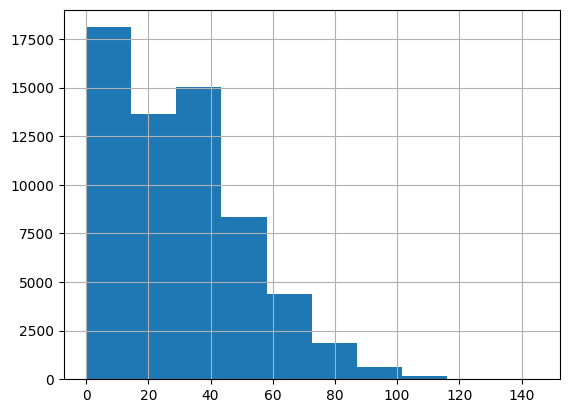

In [47]:
#look at distribution of outcome to see if transformation necessary

gym['number_people'].hist()

Our outcome variable appears to be right skewed, it's not a good idea to leave this as it will be more difficult to meet our assumptions for linear regression -- specifically, those related to our residual values. Let's transform the `number_people` column with a log-transformation to smooth things out. 

<AxesSubplot:>

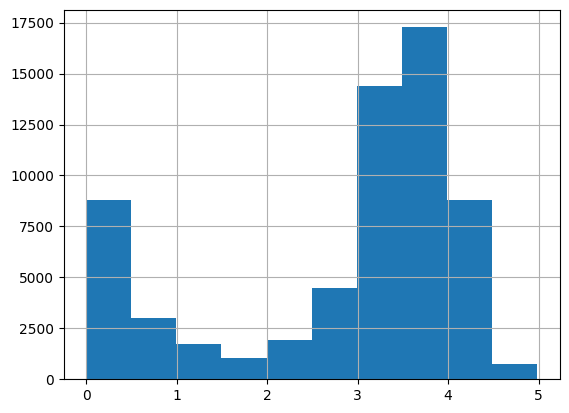

In [48]:
#zeros in the data so apply log(x+1) data
gym['log_num_ppl'] = gym['number_people'].apply(lambda x: np.log(x+1))

gym['log_num_ppl'].hist()

This is not as skewed as before, but is still not great. We can stick with the original outcome variable for now. Let's look at some of the predictors we identified as promising.

<AxesSubplot:>

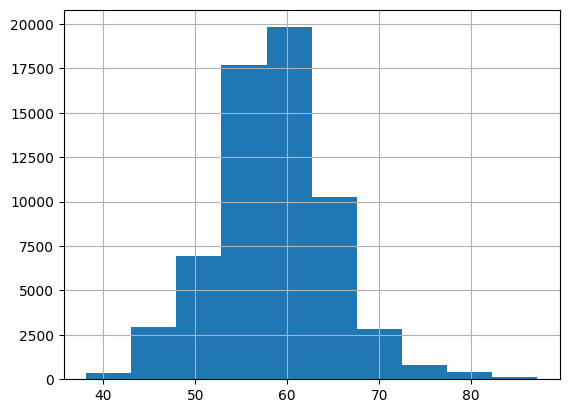

In [49]:
gym['temperature'].hist()

It seems like alot of people like going to the gym when the weather is mild outside.

<AxesSubplot:xlabel='hour', ylabel='count'>

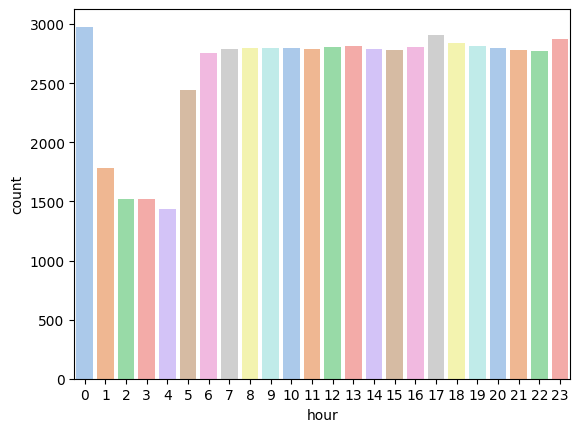

In [50]:
sns.countplot(data=gym, x='hour', palette='pastel')

It appears that most people go to the gym in the hours after 4 a.m. and before 1 a.m. 

<AxesSubplot:xlabel='is_during_semester', ylabel='count'>

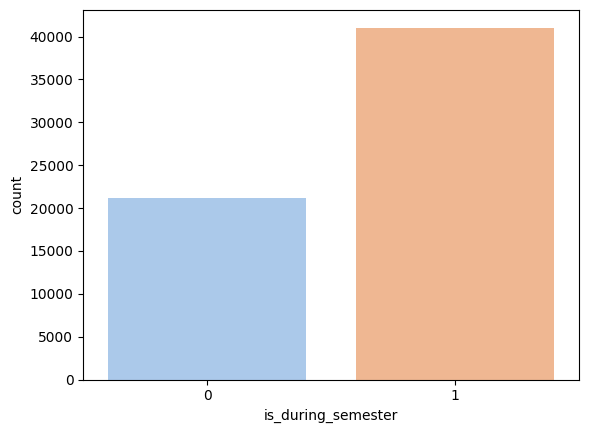

In [51]:
sns.countplot(data=gym, x='is_during_semester', palette='pastel')

Most students use the gym during the semester. 

<AxesSubplot:xlabel='is_start_of_semester', ylabel='count'>

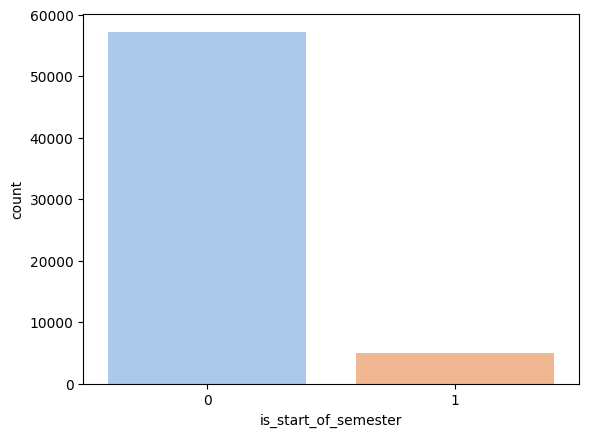

In [52]:
sns.countplot(data=gym, x='is_start_of_semester', palette='pastel')

Not alot of students appear to use the gym at the beginning of the semester. 

## Preparing Our Model

Now that we've finished our dive into the data, we can move forward with our model. 

In [53]:
#splitting the data

#chosen features
feats = ['hour', 'temperature', 'is_during_semester']

Before we split our data, an important issue must be addressed. If we want to include `hour` in our model it requires a transformation. As a categorical variable, the cyclicality of `hour` will not be captured if included in the model without a cyclical encoding. For this, we will employ a sin, cosine transfomation:

$$
xsin=sin(\frac{2∗π∗x}{max(x)})
$$

$$
xcos=cos(\frac{2∗π∗x}{max(x)})
$$

Note: We need both a sine and cosine transformation because otherwise, along one dimension (e.g. just looking at the sine transformed data), we get values for 2 hours in the day that are the same. The latter means that our model will not effectively be able to distinguish those hours from each other. 

Citation: ANDRICH VAN WYK Kaggle notebook on cyclical encoding

In [54]:
gym['hour_sin'] = np.sin(2 * np.pi * gym['hour']/24.0)
gym['hour_cos'] = np.cos(2 * np.pi * gym['hour']/24.0)

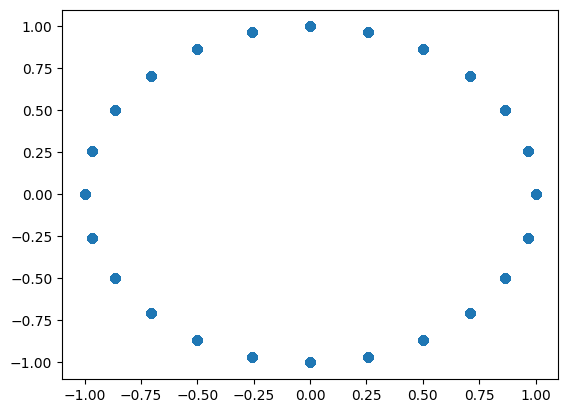

In [55]:
#look at scatter
plt.scatter(data=gym, x='hour_sin', y='hour_cos')
plt.show()

How nice! We can now split the data.

In [56]:
feats.remove('hour')
feats.append('hour_sin')
feats.append('hour_cos')

In [57]:
print(feats)

['temperature', 'is_during_semester', 'hour_sin', 'hour_cos']


In [59]:
#splitting data

X = gym[feats]
y = gym['number_people']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=417) 

#scale data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
#construct model 
sdgr = SGDRegressor(alpha=0.0001, learning_rate='optimal', 
                     loss='huber', penalty='elasticnet', random_state = 52)

#fitting model to training data
sdgr.fit(X_train_scaled, y_train)

SGDRegressor(learning_rate='optimal', loss='huber', penalty='elasticnet',
             random_state=52)

## Initial Evaluation

Let's calculate some metrics to see how our model performs on the test data.

In [65]:
#get prediction 

y_pred = sdgr.predict(X_test_scaled)

In [67]:
#calc metrics

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse.round(4)}')

r_2 = r2_score(y_test, y_pred)
print(f'R-Squared: {r_2.round(4)}')

RMSE: 16.5665
R-Squared: 0.4662


Below is a breakdown of the performance metrics of our model. 

RMSE: This value is high, very high, which is not good. This metric describes the average squared difference between the real values and predicted values from our model, in the same terms as the outcome variable. 

R-Squared: This value is low, which is also not satisfactory. This value describes the amount of variation explained by our model. In other words, 46% of the variation in `number_people` was explained by taking `temperature`, `is_during_semester` and `hour` into account. 

## Assumptions

As an exercise, let's do a quick overview of the assumptions of Linear Regression, and see how our model stacks up.

Recall, from our last project, the assumptions: 

1. Linearity: The average outcome must be linearly related to each predictor holding the others fixed.

2. Normal Distribution of the Errors: The residuals must follow a normal distribution with their mean centered at zero.

3. No Heteroscedasticity : This describes a situation where the variance of our residuals are not constant -- we do not want this. One can evaluate the latter with a residual plot where the residuals are plotted on the y-axis against our predicted values on the x-axis.

4. No Multicollinearity: We cannot allow for any 2 predictors in our model to maintain strong correlations with each-other. The latter situation makes it difficult to reliably calculate our coefficients. We can evaluate this by looking at a correlation matrix.

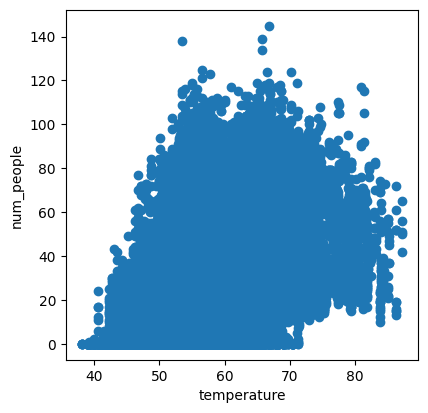

In [77]:
#linearity


fig = plt.figure(figsize=(10,10))

fig.add_subplot(221)
plt.scatter(data=gym, x='temperature', y='number_people')
plt.xlabel('temperature')
plt.ylabel('num_people')

plt.show()

There appears to exist a linear relationship between `temperature` and `number_people`. The other two predictors are categorical, so they satisfy the linearity assumption by default. 

<AxesSubplot:>

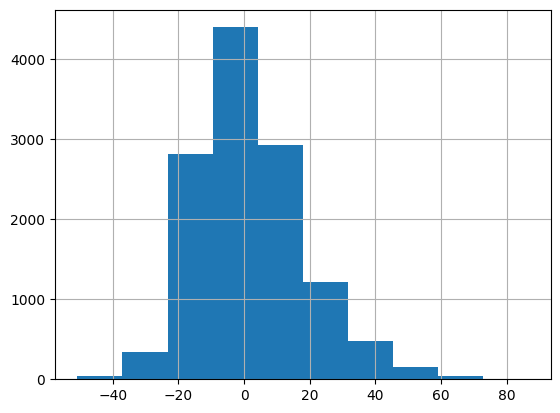

In [78]:
#Normal distribution of errors

residuals = y_test - y_pred

residuals.hist()

This looks good! Our residuals appear relativley normally distributed with their mean centered at zero. 

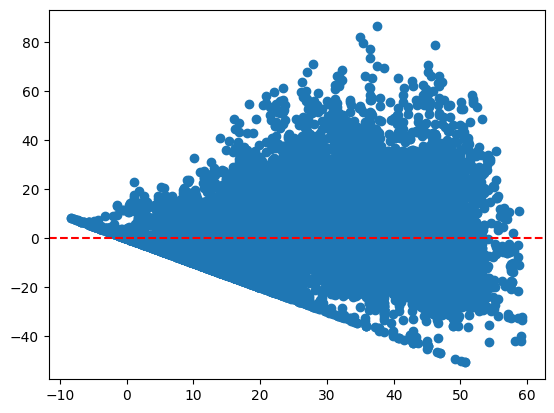

In [81]:
#Homosked

#creating residual plot with residuals on y-axis and predicted values on x

plt.scatter(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='r')
plt.show()

Our homoscedasticity assumption has been violated. The variance of the residuals is not constant, i.e. the dispersion from our residuals plot is heteroskedastic. To fix this, we should consider transforming our outcome variable. 

In [83]:
#Multicoll

gym.corr().unstack()[feats].sort_values(ascending=False).drop_duplicates().head(10)

hour_cos            hour_cos                1.000000
temperature         log_num_ppl             0.384715
                    number_people           0.373327
is_during_semester  number_people           0.335350
                    log_num_ppl             0.253387
                    is_start_of_semester    0.209862
temperature         hour                    0.185121
                    is_during_semester      0.152476
is_during_semester  month                   0.096556
temperature         is_start_of_semester    0.093242
dtype: float64

There do not appear to be any excessively high correlations amongst our features. 

## Reconstructing Model With Transformed Data

Because our homoscedasticity assumption has been violated, the predictive ability of our model is now into question. The OLS estimators are no longer the best linear unbiased estimators (BLUE), and because they are inefficient so are our predictions.

Let's try and reconstruct our model with the log-transformed data from earlier, and see if that changes anything.

In [88]:
#splitting 

X_recon = X
y_recon = gym['log_num_ppl']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_recon, y_recon, test_size=.2, random_state=417)

#scale -- standardizing
X_train_scaled_r = scaler.fit_transform(X_train_r)
X_test_scaled_r = scaler.transform(X_test_r)

#creating new model
sgdr1 = SGDRegressor(alpha=0.0001, learning_rate='optimal', 
                     loss='huber', penalty='elasticnet', random_state = 52)

#fitting 
sgdr1.fit(X_train_scaled_r, y_train_r)

SGDRegressor(learning_rate='optimal', loss='huber', penalty='elasticnet',
             random_state=52)

In [90]:
#predicting
y_pred_r = sgdr1.predict(X_test_scaled_r)

#calc residuals
residuals_r = y_test_r - y_pred_r

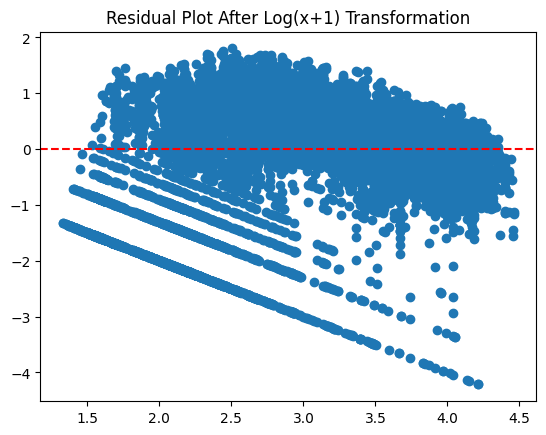

In [92]:
#residual plot

plt.scatter(x=y_pred_r, y=residuals_r)
plt.axhline(0, linestyle='--', color='r')
plt.title('Residual Plot After Log(x+1) Transformation')
plt.show()

This does look better than it did before... let's check our model metrics. 

In [94]:
r_2_r = r2_score(y_test_r, y_pred_r)
print(r_2_r)

0.463605898622255


Our R-Squared does not appear to have changed. It does not seem like our model has improved in its ability to explain the variation in the outcome variable with the given predictors. 

## Visualizing Our Results

Let's see how our actual and predicted values compare graphically. 

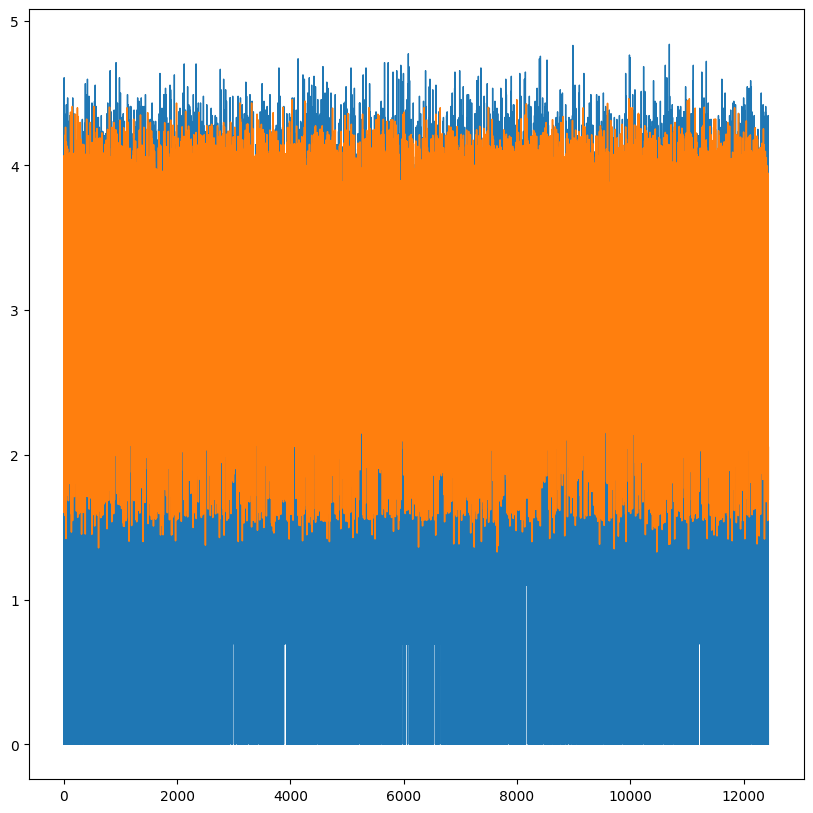

In [108]:
plt.figure(figsize=(10, 10))

plt.plot(range(len(y_test_r)),y_test_r, linewidth=1 )
plt.plot(range(len(y_test_r)),y_pred_r, linewidth=1.1 )

This graph depicts the true values in blue plotted against the predictions in orange. As one can see by the lack of coverage, the model is not performing well across the whole spectrum of outcome values.  

## Conclusion

In the end, our regression model with stochastic gradient descent was not successful in reliably predicting the amount of people at the gym. That said, based on our earlier exploratory analysis, if one goes to the gym in the window before 6 a.m. and after midnight, they should face a near non-existant crowd. 

This model might be improved by including more predictors, testing different hyperparameters, or collecting more data. 